In [70]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum,count,round , lit,when,substring,avg,countDistinct,floor,max,min
import matplotlib.pyplot as plt
import seaborn as sns
import locale
import pandas as pd
import plotly.express as px
import time
import os

caminho =r'D:/base_ans_parquet/'

anos_filtrar = ["2023", "2024", "2025"]

arquivos_parquet = [
    os.path.join(caminho, f)
    for f in os.listdir(caminho)
    if f.endswith(".parquet") and any(ano in f for ano in anos_filtrar)
]

spark = SparkSession.builder.appName("LeituraParquet").config("spark.driver.memory", "12g").getOrCreate()
inicio = time.time()

spark.conf.set("spark.sql.execution.pyspark.udf.faulthandler.enabled", "true")

df = spark.read.parquet(*arquivos_parquet)
total_registros = df.count()  # Força leitura e conta registros
fim = time.time()

print(f"Total de registros: {total_registros}")
print(f"Tempo de leitura: {fim - inicio:.2f} segundos")

Total de registros: 421212923
Tempo de leitura: 2.51 segundos


In [72]:
#FILTRAR DADOS
df_soma0 = df.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma0.show()
#FILTRAR APENAS USUARIOS DE PLANO DE SAUDE, EXCLUIR ODONTOLOGICO 
df_filtrado = df.filter(
    (col("COBERTURA_ASSIST_PLAN") == "Médico-hospitalar")     
)
df_soma = df_filtrado.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma.show()


#REMOVER USUARIOS SEM FAIXA ETARIA, SEM VINCULO
df_filtrado2345 = df_filtrado.filter(
    (col("DE_FAIXA_ETARIA") != "Informada Incorr") &
    (col("TIPO_VINCULO") != "Não Identificado") &
    (col("SG_UF") != "XX") &
    (col("DE_CONTRATACAO_PLANO") != "Não Identificado")
)
df_soma2 = df_filtrado2345.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma2.show()

df_filtrado6 = df_filtrado2345.filter(
    col("ID_CMPT_MOVEL").like("2025%")
)


df_somagroupby = df_filtrado6.groupBy("DE_FAIXA_ETARIA_REAJ", "TIPO_VINCULO").agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_valor"))


df_somagroupby.show(200)




+--------------------+------------+----------+
|DE_FAIXA_ETARIA_REAJ|TIPO_VINCULO|soma_valor|
+--------------------+------------+----------+
|        44 a 48 anos|     Titular|  15411602|
|        24 a 28 anos|     Titular|  13646895|
|        39 a 43 anos|  Dependente|   7429140|
|        29 a 33 anos|  Dependente|   5907899|
|        49 a 53 anos|  Dependente|   4733795|
|          59 ou mais|  Dependente|  11572674|
|          59 ou mais|     Titular|  30434499|
|        19 a 23 anos|     Titular|   7965900|
|        39 a 43 anos|     Titular|  18175528|
|        24 a 28 anos|  Dependente|   5390732|
|        54 a 58 anos|  Dependente|   3847381|
|         0 a 18 anos|  Dependente|  50243127|
|        44 a 48 anos|  Dependente|   6339086|
|        54 a 58 anos|     Titular|   9512214|
|         0 a 18 anos|     Titular|   9647955|
|        29 a 33 anos|     Titular|  15993642|
|        19 a 23 anos|  Dependente|   7888238|
|        34 a 38 anos|     Titular|  17548436|
|        49 a

In [3]:
#AMOSTRA JANEIRO/25
df_filtrado6 = df_filtrado2345.filter(
    col("ID_CMPT_MOVEL").like("2025%")
)

df_soma3 = df_filtrado6.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma3.show()

df_somagroupby = df_filtrado2345.groupBy("ID_CMPT_MOVEL").agg(
    sum("QT_BENEFICIARIO_CANCELADO").alias("soma_valor")
)
df_somagroupby.show(100)


+-------------+----------+
|ID_CMPT_MOVEL|soma_valor|
+-------------+----------+
|      2025-04|   1177435|
|      2025-03|   1179761|
|      2025-01|   1164019|
|      2025-02|   1212828|
|      2024-12|   1099647|
|      2024-10|   1285058|
|      2024-09|   1261438|
|      2024-11|   1224316|
|      2024-08|   1206388|
|      2024-04|   1911842|
|      2024-06|   1328394|
|      2024-07|   1204652|
|      2024-05|   1263582|
|      2024-01|   1379268|
|      2024-02|   1143624|
|      2024-03|   1194916|
|      2023-12|   1152892|
|      2023-11|   1156655|
|      2023-08|   1439274|
|      2023-09|   1247351|
|      2023-07|   1194124|
|      2023-10|   1192890|
|      2023-05|   1256803|
|      2023-06|   1236804|
|      2023-03|   1199037|
|      2023-04|   1171155|
|      2023-02|   1215407|
|      2023-01|   1184722|
|      2025-05|    965859|
+-------------+----------+



In [17]:
#VERIFICAR DUPLICIDADE DA BASE
#tem_duplicatas = df_filtrado6.groupBy(df.columns).count().filter("count > 1").limit(1).count() > 0

#if tem_duplicatas:
#    print("Há duplicatas.")
#else:
#    print("Nenhuma duplicata encontrada.")


Nenhuma duplicata encontrada.


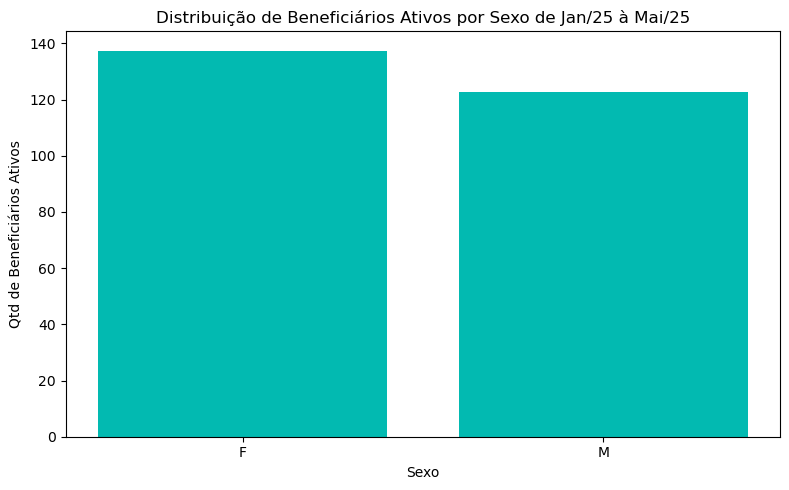

TP_SEXO,Soma_Beneficiarios_Ativos,Frequencia_Relativa_%
F,137.421.482,"52,8%"
M,122.838.095,"47,2%"


In [177]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
def zebra_style(row):
    # Aplica cor de fundo cinza nas linhas pares
    color = '#f2f2f2' if row.name % 2 == 0 else 'white'
    return ['background-color: {}'.format(color)] * len(row)
    
def format_number_brl(x):
    # Formata número com separador de milhar ponto, sem casas decimais
    return locale.format_string("%d", int(x), grouping=True)

def format_percentage_comma(x):
    # Formata percentual com vírgula decimal e 2 casas decimais, e % no final
    return f"{x:.1f}".replace('.', ',') + '%'    
    
soma_total = df_filtrado6.agg(sum("QT_BENEFICIARIO_ATIVO")).first()[0]

# TP_SEXO
df_sexo = df_filtrado6.groupBy("TP_SEXO") \
    .agg(sum("QT_BENEFICIARIO_ATIVO").alias("Soma_Beneficiarios_Ativos")) \
    .orderBy("Soma_Beneficiarios_Ativos", ascending=False)

pdf_sexo = df_sexo.toPandas()
pdf_sexo_graf = df_sexo.toPandas()
pdf_sexo_graf['Soma_Beneficiarios_Ativos'] = pdf_sexo['Soma_Beneficiarios_Ativos'] / 1_000_000
pdf_sexo["Frequencia_Relativa_%"] = (pdf_sexo["Soma_Beneficiarios_Ativos"] / pdf_sexo["Soma_Beneficiarios_Ativos"].sum() * 100).round(2)
#print("Tabela de Frequência - TP_SEXO:")
#print(pdf_sexo)

plt.figure(figsize=(8, 5))
plt.bar(pdf_sexo_graf["TP_SEXO"], pdf_sexo_graf["Soma_Beneficiarios_Ativos"], color='#02bab1')
plt.title("Distribuição de Beneficiários Ativos por Sexo de Jan/25 à Mai/25")
plt.xlabel("Sexo")
plt.ylabel("Qtd de Beneficiários Ativos")
plt.tight_layout()
plt.show()

styled_table = pdf_sexo.style \
    .apply(zebra_style, axis=1) \
    .format({
        "Soma_Beneficiarios_Ativos": format_number_brl,
        "Frequencia_Relativa_%": format_percentage_comma
    }) \
    .set_properties(**{'border': '1px solid black'}) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', '#02bab1'),
                      ('color', 'white'),
                      ('border', '1px solid black'),
                      ('text-align', 'center')]
        }
    ]) \
    .hide(axis='index')


display(styled_table)


pdf_sexo = df_sexo.toPandas()

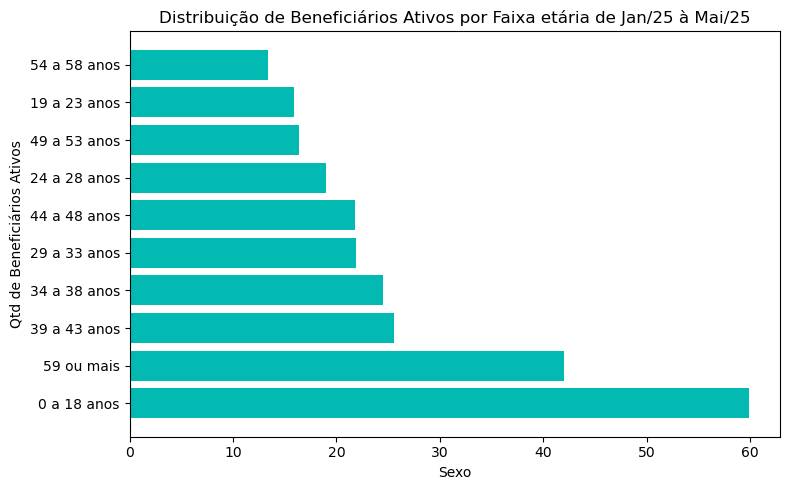

DE_FAIXA_ETARIA_REAJ,Soma_Beneficiarios_Ativos,Frequencia_Relativa_%
0 a 18 anos,59.891082,"23,0%"
59 ou mais,42.007173,"16,1%"
39 a 43 anos,25.604668,"9,8%"
34 a 38 anos,24.491884,"9,4%"
29 a 33 anos,21.901541,"8,4%"
44 a 48 anos,21.750688,"8,4%"
24 a 28 anos,19.037627,"7,3%"
49 a 53 anos,16.361181,"6,3%"
19 a 23 anos,15.854138,"6,1%"
54 a 58 anos,13.359595,"5,1%"


In [107]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
def zebra_style(row):
    # Aplica cor de fundo cinza nas linhas pares
    color = '#f2f2f2' if row.name % 2 == 0 else 'white'
    return ['background-color: {}'.format(color)] * len(row)
    
def format_number_brl(x):
    # Formata número com separador de milhar ponto, sem casas decimais
    return locale.format_string("%d", int(x), grouping=True)

def format_percentage_comma(x):
    # Formata percentual com vírgula decimal e 2 casas decimais, e % no final
    return f"{x:.1f}".replace('.', ',') + '%'    
    
soma_total = df_filtrado6.agg(sum("QT_BENEFICIARIO_ATIVO")).first()[0]

# TP_SEXO
df_idade = df_filtrado6.groupBy("DE_FAIXA_ETARIA") \
    .agg(sum("QT_BENEFICIARIO_ATIVO").alias("Soma_Beneficiarios_Ativos")) \
    .orderBy("Soma_Beneficiarios_Ativos", ascending=False)

pdf_idade = df_idade.toPandas()
pdf_idade['Soma_Beneficiarios_Ativos'] = pdf_idade['Soma_Beneficiarios_Ativos'] / 1_000_000
pdf_idade["Frequencia_Relativa_%"] = (pdf_idade["Soma_Beneficiarios_Ativos"] / pdf_idade["Soma_Beneficiarios_Ativos"].sum() * 100).round(2)
#print("Tabela de Frequência - TP_SEXO:")
#print(pdf_idade)

plt.figure(figsize=(8, 5))
plt.barh(pdf_idade["DE_FAIXA_ETARIA"], pdf_idade["Soma_Beneficiarios_Ativos"], color='#02bab1')
plt.title("Distribuição de Beneficiários Ativos por Faixa etária de Jan/25 à Mai/25")
plt.xlabel("Sexo")
plt.ylabel("Qtd de Beneficiários Ativos")
plt.tight_layout()
plt.show()

styled_table = pdf_idade.style \
    .apply(zebra_style, axis=1) \
    .format({
        "Beneficiarios_Ativos": format_number_brl,
        "Frequencia_Relativa_%": format_percentage_comma
    }) \
    .set_properties(**{'border': '1px solid black'}) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', '#02bab1'),
                      ('color', 'white'),
                      ('border', '1px solid black'),
                      ('text-align', 'center')]
        }
    ]) \
    .hide(axis='index')


display(styled_table)



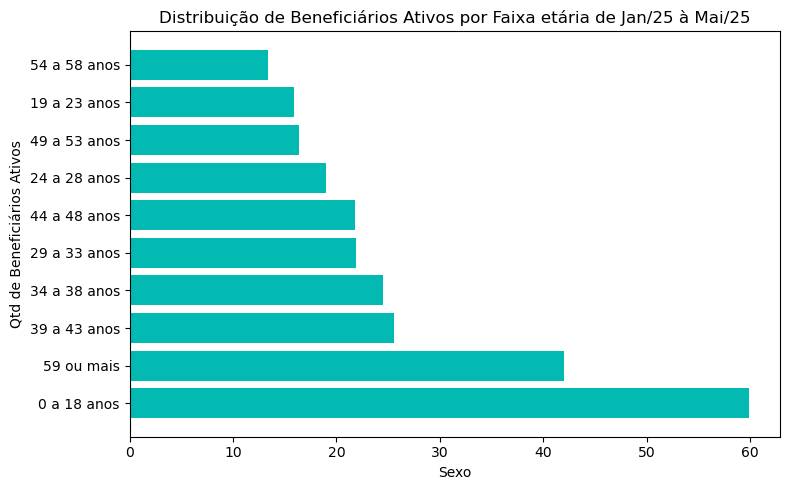

DE_FAIXA_ETARIA_REAJ,Soma_Beneficiarios_Ativos,Frequencia_Relativa_%
0 a 18 anos,59.891082,"23,0%"
59 ou mais,42.007173,"16,1%"
39 a 43 anos,25.604668,"9,8%"
34 a 38 anos,24.491884,"9,4%"
29 a 33 anos,21.901541,"8,4%"
44 a 48 anos,21.750688,"8,4%"
24 a 28 anos,19.037627,"7,3%"
49 a 53 anos,16.361181,"6,3%"
19 a 23 anos,15.854138,"6,1%"
54 a 58 anos,13.359595,"5,1%"


In [120]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
def zebra_style(row):
    # Aplica cor de fundo cinza nas linhas pares
    color = '#f2f2f2' if row.name % 2 == 0 else 'white'
    return ['background-color: {}'.format(color)] * len(row)
    
def format_number_brl(x):
    # Formata número com separador de milhar ponto, sem casas decimais
    return locale.format_string("%d", int(x), grouping=True)

def format_percentage_comma(x):
    # Formata percentual com vírgula decimal e 2 casas decimais, e % no final
    return f"{x:.1f}".replace('.', ',') + '%'    
    
soma_total = df_filtrado6.agg(sum("QT_BENEFICIARIO_ATIVO")).first()[0]

# TP_SEXO
df_idade = df_filtrado6.groupBy("DE_FAIXA_ETARIA_REAJ") \
    .agg(sum("QT_BENEFICIARIO_ATIVO").alias("Soma_Beneficiarios_Ativos")) \
    .orderBy("Soma_Beneficiarios_Ativos", ascending=False)

pdf_idade = df_idade.toPandas()
pdf_idade['Soma_Beneficiarios_Ativos'] = pdf_idade['Soma_Beneficiarios_Ativos'] / 1_000_000
pdf_idade["Frequencia_Relativa_%"] = (pdf_idade["Soma_Beneficiarios_Ativos"] / pdf_idade["Soma_Beneficiarios_Ativos"].sum() * 100).round(2)
#print("Tabela de Frequência - TP_SEXO:")
#print(pdf_idade)

plt.figure(figsize=(8, 5))
plt.barh(pdf_idade["DE_FAIXA_ETARIA_REAJ"], pdf_idade["Soma_Beneficiarios_Ativos"], color='#02bab1')
plt.title("Distribuição de Beneficiários Ativos por Faixa etária de Jan/25 à Mai/25")
plt.xlabel("Sexo")
plt.ylabel("Qtd de Beneficiários Ativos")
plt.tight_layout()
plt.show()

styled_table = pdf_idade.style \
    .apply(zebra_style, axis=1) \
    .format({
        "Beneficiarios_Ativos": format_number_brl,
        "Frequencia_Relativa_%": format_percentage_comma
    }) \
    .set_properties(**{'border': '1px solid black'}) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', '#02bab1'),
                      ('color', 'white'),
                      ('border', '1px solid black'),
                      ('text-align', 'center')]
        }
    ]) \
    .hide(axis='index')


display(styled_table)


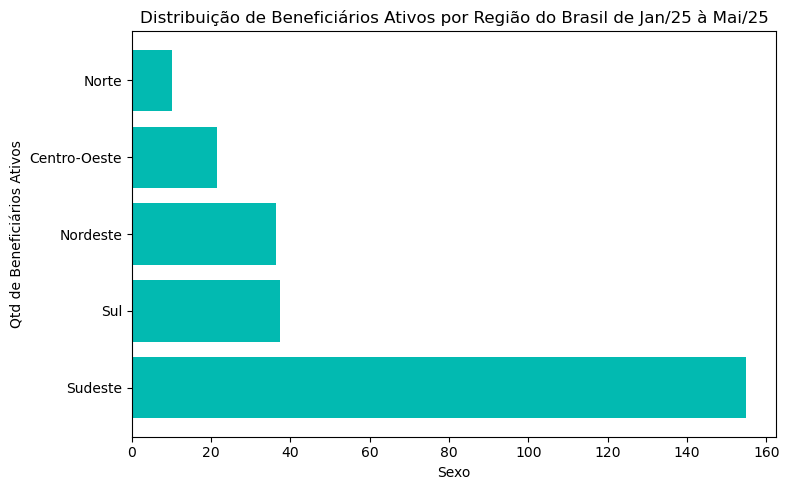

REGIAO,Soma_Beneficiarios_Ativos,Frequencia_Relativa_%
Sudeste,154.783450,"59,5%"
Sul,37.467120,"14,4%"
Nordeste,36.465280,"14,0%"
Centro-Oeste,21.441194,"8,2%"
Norte,10.102533,"3,9%"


In [127]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
def zebra_style(row):
    # Aplica cor de fundo cinza nas linhas pares
    color = '#f2f2f2' if row.name % 2 == 0 else 'white'
    return ['background-color: {}'.format(color)] * len(row)
    
def format_number_brl(x):
    # Formata número com separador de milhar ponto, sem casas decimais
    return locale.format_string("%d", int(x), grouping=True)

def format_percentage_comma(x):
    # Formata percentual com vírgula decimal e 2 casas decimais, e % no final
    return f"{x:.1f}".replace('.', ',') + '%'    

df_uf = df_filtrado6.withColumn(
    "REGIAO",
    when(df_filtrado6.SG_UF.isin("SP", "MG", "RJ", "ES"), "Sudeste")
    .when(df_filtrado6.SG_UF.isin("PR", "RS", "SC"), "Sul")
    .when(df_filtrado6.SG_UF.isin("GO", "DF", "MS", "MT"), "Centro-Oeste")
    .when(df_filtrado6.SG_UF.isin("BA", "CE", "PE", "MA", "RN", "PB", "PI", "AL", "SE"), "Nordeste")
    .when(df_filtrado6.SG_UF.isin("AM", "PA", "RO", "TO", "AP", "AC", "RR"), "Norte")
    .otherwise("Outros")
)    
    
soma_total = df_filtrado6.agg(sum("QT_BENEFICIARIO_ATIVO")).first()[0]

# TP_SEXO
df_uf_agg = df_uf.groupBy("REGIAO") \
    .agg(sum("QT_BENEFICIARIO_ATIVO").alias("Soma_Beneficiarios_Ativos")) \
    .orderBy("Soma_Beneficiarios_Ativos", ascending=False)

pdf_uf = df_uf_agg.toPandas()
pdf_uf['Soma_Beneficiarios_Ativos'] = pdf_uf['Soma_Beneficiarios_Ativos'] / 1_000_000
pdf_uf["Frequencia_Relativa_%"] = (pdf_uf["Soma_Beneficiarios_Ativos"] / pdf_uf["Soma_Beneficiarios_Ativos"].sum() * 100).round(2)
#print("Tabela de Frequência - TP_SEXO:")
#print(pdf_uf)

plt.figure(figsize=(8, 5))
plt.barh(pdf_uf["REGIAO"], pdf_uf["Soma_Beneficiarios_Ativos"], color='#02bab1')
plt.title("Distribuição de Beneficiários Ativos por Região do Brasil de Jan/25 à Mai/25")
plt.xlabel("Sexo")
plt.ylabel("Qtd de Beneficiários Ativos")
plt.tight_layout()
plt.show()

styled_table = pdf_uf.style \
    .apply(zebra_style, axis=1) \
    .format({
        "Beneficiarios_Ativos": format_number_brl,
        "Frequencia_Relativa_%": format_percentage_comma
    }) \
    .set_properties(**{'border': '1px solid black'}) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', '#02bab1'),
                      ('color', 'white'),
                      ('border', '1px solid black'),
                      ('text-align', 'center')]
        }
    ]) \
    .hide(axis='index')


display(styled_table)


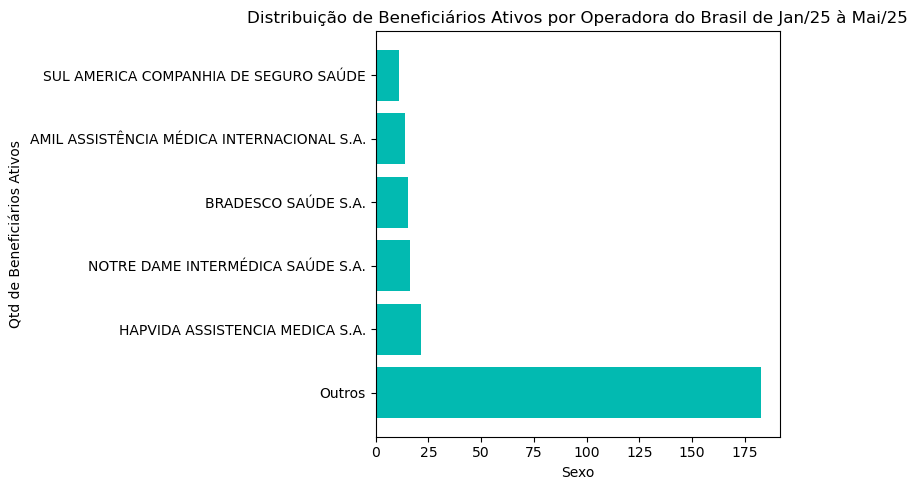

Categoria,Soma_Beneficiarios_Ativos,Frequencia_Relativa_%
Outros,182.592743,"70,2%"
HAPVIDA ASSISTENCIA MEDICA S.A.,21.346958,"8,2%"
NOTRE DAME INTERMÉDICA SAÚDE S.A.,16.269594,"6,2%"
BRADESCO SAÚDE S.A.,15.377503,"5,9%"
AMIL ASSISTÊNCIA MÉDICA INTERNACIONAL S.A.,13.721956,"5,3%"
SUL AMERICA COMPANHIA DE SEGURO SAÚDE,10.950823,"4,2%"


In [130]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
def zebra_style(row):
    # Aplica cor de fundo cinza nas linhas pares
    color = '#f2f2f2' if row.name % 2 == 0 else 'white'
    return ['background-color: {}'.format(color)] * len(row)
    
def format_number_brl(x):
    # Formata número com separador de milhar ponto, sem casas decimais
    return locale.format_string("%d", int(x), grouping=True)

def format_percentage_comma(x):
    # Formata percentual com vírgula decimal e 2 casas decimais, e % no final
    return f"{x:.1f}".replace('.', ',') + '%'    

#PARA EMPRESAS FAZER TOP 5 E OUTROS
coluna = "NM_RAZAO_SOCIAL"
top5_vals = [row[coluna] for row in df_filtrado6.groupBy(coluna)
    .agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_benef"))
    .orderBy(col("soma_benef").desc())
    .limit(5)
    .collect()]

# Criar coluna nova que categoriza em Top5 ou Outros
df_operadora = df_filtrado6.withColumn(
    "Categoria",
    when(col(coluna).isin(top5_vals), col(coluna)).otherwise(lit("Outros"))
)

resultado = df_operadora.groupBy("Categoria") \
    .agg(
        sum("QT_BENEFICIARIO_ATIVO").alias("Soma_Beneficiarios_Ativos"),
        round((sum("QT_BENEFICIARIO_ATIVO") / soma_total) * 100, 2).alias("Frequencia_Relativa_%")
    ) \
    .orderBy(col("Soma_Beneficiarios_Ativos").desc())
    

pdf_operadora_agg = resultado.toPandas()
pdf_operadora_agg['Soma_Beneficiarios_Ativos'] = pdf_operadora_agg['Soma_Beneficiarios_Ativos'] / 1_000_000
pdf_operadora_agg["Frequencia_Relativa_%"] = (pdf_operadora_agg["Soma_Beneficiarios_Ativos"] / pdf_operadora_agg["Soma_Beneficiarios_Ativos"].sum() * 100).round(2)
#print("Tabela de Frequência - TP_SEXO:")
#print(pdf_operadora_agg)

plt.figure(figsize=(8, 5))
plt.barh(pdf_operadora_agg["Categoria"], pdf_operadora_agg["Soma_Beneficiarios_Ativos"], color='#02bab1')
plt.title("Distribuição de Beneficiários Ativos por Operadora do Brasil de Jan/25 à Mai/25")
plt.xlabel("Sexo")
plt.ylabel("Qtd de Beneficiários Ativos")
plt.tight_layout()
plt.show()

styled_table = pdf_operadora_agg.style \
    .apply(zebra_style, axis=1) \
    .format({
        "Beneficiarios_Ativos": format_number_brl,
        "Frequencia_Relativa_%": format_percentage_comma
    }) \
    .set_properties(**{'border': '1px solid black'}) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', '#02bab1'),
                      ('color', 'white'),
                      ('border', '1px solid black'),
                      ('text-align', 'center')]
        }
    ]) \
    .hide(axis='index')


display(styled_table)


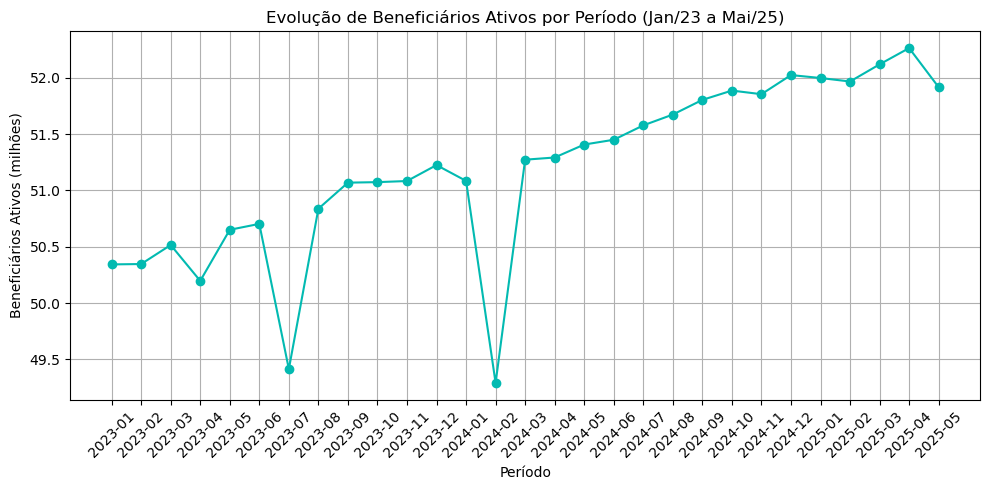

+----+----------+---------------+
| ANO|soma_valor|meses_distintos|
+----+----------+---------------+
|2025| 260259577|              5|
|2023| 607460160|             12|
|2024| 616612100|             12|
+----+----------+---------------+



ANO,Média Anual de Beneficiários
2.023,50.621.680
2.024,51.384.341
2.025,52.051.915


In [196]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
def zebra_style(row):
    # Aplica cor de fundo cinza nas linhas pares
    color = '#f2f2f2' if row.name % 2 == 0 else 'white'
    return ['background-color: {}'.format(color)] * len(row)
    
def format_number_brl(x):
    # Formata número com separador de milhar ponto, sem casas decimais
    return locale.format_string("%d", int(x), grouping=True)

def format_percentage_comma(x):
    # Formata percentual com vírgula decimal e 2 casas decimais, e % no final
    return f"{x:.1f}".replace('.', ',') + '%'    
    
soma_total = df_filtrado2345.agg(sum("QT_BENEFICIARIO_ATIVO")).first()[0]

# PERIODO
df_periodo = df_filtrado2345.groupBy("ID_CMPT_MOVEL") \
    .agg(sum("QT_BENEFICIARIO_ATIVO").alias("Soma_Beneficiarios_Ativos")) \
    .orderBy("Soma_Beneficiarios_Ativos", ascending=False)

pdf_periodo = df_periodo.toPandas().sort_values("ID_CMPT_MOVEL")
pdf_periodo['Soma_Beneficiarios_Ativos'] = pdf_periodo['Soma_Beneficiarios_Ativos'] / 1_000_000

plt.figure(figsize=(10, 5))
plt.plot(pdf_periodo["ID_CMPT_MOVEL"], pdf_periodo["Soma_Beneficiarios_Ativos"], marker='o', color='#02bab1', linestyle='-')
plt.title("Evolução de Beneficiários Ativos por Período (Jan/23 a Mai/25)")
plt.xlabel("Período")
plt.ylabel("Beneficiários Ativos (milhões)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

df_ano = df_filtrado2345.withColumn("ANO", substring("ID_CMPT_MOVEL", 1, 4))

df_ano_avg_real = df_ano.groupBy("ANO").agg(
    sum("QT_BENEFICIARIO_ATIVO").alias("soma_valor"),    
    countDistinct("ID_CMPT_MOVEL").alias("meses_distintos")
)

# Calculando a média real por mês
df_ano_avg_real = df_ano_avg_real.withColumn(
    "media_mensal_real",
    col("soma_valor") / col("meses_distintos")    
)

pdf_ano = df_ano_avg_real.toPandas()
pdf_ano["media_mensal_real"] = pdf_ano["media_mensal_real"] 
pdf_ano_media = pdf_ano[["ANO", "media_mensal_real"]].rename(
    columns={"media_mensal_real": "Média Anual de Beneficiários"}
)

pdf_ano_media = pdf_ano_media.sort_values("ANO")

styled_table = pdf_ano_media.style \
    .apply(zebra_style, axis=1) \
    .format({
        "ANO": format_number_brl,
        "Média Anual de Beneficiários": format_number_brl

    }) \
    .set_properties(**{'border': '1px solid black'}) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', '#02bab1'),
                      ('color', 'white'),
                      ('border', '1px solid black'),
                      ('text-align', 'center')]
        }
    ]) \
    .hide(axis='index')


display(styled_table)



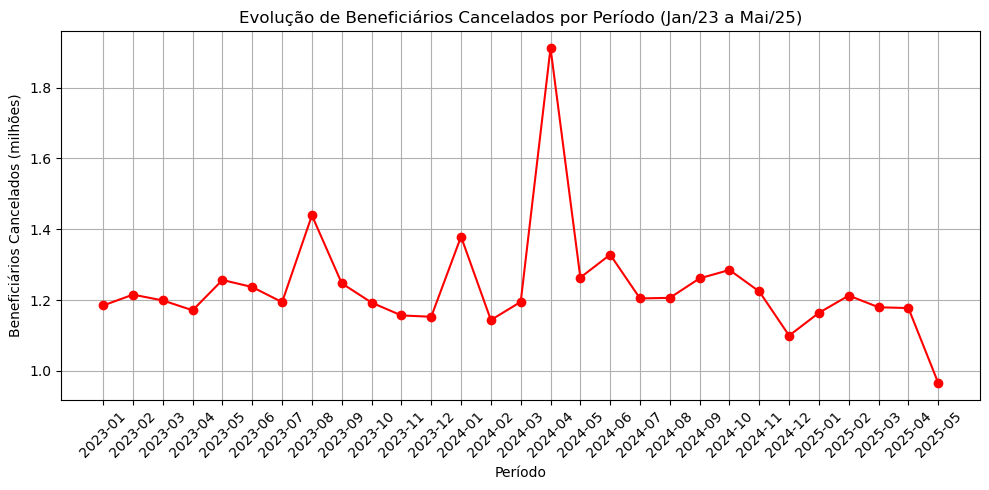

ANO,Média Anual de Beneficiários Cancelados
2023,1.220.592
2024,1.291.927
2025,1.139.980


In [204]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
def zebra_style(row):
    # Aplica cor de fundo cinza nas linhas pares
    color = '#f2f2f2' if row.name % 2 == 0 else 'white'
    return ['background-color: {}'.format(color)] * len(row)
    
def format_number_brl(x):
    # Formata número com separador de milhar ponto, sem casas decimais
    return locale.format_string("%d", int(x), grouping=True)

def format_percentage_comma(x):
    # Formata percentual com vírgula decimal e 2 casas decimais, e % no final
    return f"{x:.1f}".replace('.', ',') + '%'    
    
soma_total = df_filtrado2345.agg(sum("QT_BENEFICIARIO_CANCELADO")).first()[0]

# PERIODO
df_periodo = df_filtrado2345.groupBy("ID_CMPT_MOVEL") \
    .agg(sum("QT_BENEFICIARIO_CANCELADO").alias("Soma_Beneficiarios_Cancelados")) \
    .orderBy("Soma_Beneficiarios_Cancelados", ascending=False)

pdf_periodo = df_periodo.toPandas().sort_values("ID_CMPT_MOVEL")
pdf_periodo['Soma_Beneficiarios_Cancelados'] = pdf_periodo['Soma_Beneficiarios_Cancelados'] / 1_000_000


plt.figure(figsize=(10, 5))
plt.plot(pdf_periodo["ID_CMPT_MOVEL"], pdf_periodo["Soma_Beneficiarios_Cancelados"], marker='o', color='red', linestyle='-')
plt.title("Evolução de Beneficiários Cancelados por Período (Jan/23 a Mai/25)")
plt.xlabel("Período")
plt.ylabel("Beneficiários Cancelados (milhões)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



#TABELAS
df_ano = df_filtrado2345.withColumn("ANO", substring("ID_CMPT_MOVEL", 1, 4))

df_ano_avg_real = df_ano.groupBy("ANO").agg(
    sum("QT_BENEFICIARIO_CANCELADO").alias("soma_valor"),    
    countDistinct("ID_CMPT_MOVEL").alias("meses_distintos")
)

# Calculando a média real por mês
df_ano_avg_real = df_ano_avg_real.withColumn(
    "media_mensal_real",
    col("soma_valor") / col("meses_distintos")    
)

pdf_ano = df_ano_avg_real.toPandas()
pdf_ano["media_mensal_real"] = pdf_ano["media_mensal_real"] 
pdf_ano_media = pdf_ano[["ANO", "media_mensal_real"]].rename(
    columns={"media_mensal_real": "Média Anual de Beneficiários Cancelados"}
)

pdf_ano_media = pdf_ano_media.sort_values("ANO")

styled_table = pdf_ano_media.style \
    .apply(zebra_style, axis=1) \
    .format({
        "Ano": format_number_brl,
        "Média Anual de Beneficiários Cancelados": format_number_brl

    }) \
    .set_properties(**{'border': '1px solid black'}) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', '#02bab1'),
                      ('color', 'white'),
                      ('border', '1px solid black'),
                      ('text-align', 'center')]
        }
    ]) \
    .hide(axis='index')


display(styled_table)



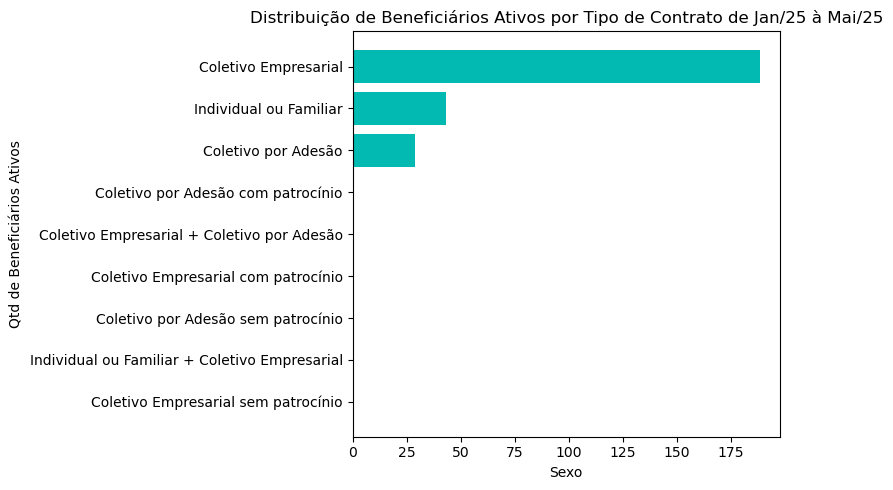

DE_CONTRATACAO_PLANO,Soma_Beneficiarios_Ativos,Frequencia_Relativa_%
Coletivo Empresarial,188.137.284,"72,3%"
Individual ou Familiar,43.034.393,"16,5%"
Coletivo por Adesão,29.083.033,"11,2%"
Coletivo por Adesão com patrocínio,3.337,"0,0%"
Coletivo Empresarial + Coletivo por Adesão,1.090,"0,0%"
Coletivo Empresarial com patrocínio,180,"0,0%"
Coletivo por Adesão sem patrocínio,160,"0,0%"
Individual ou Familiar + Coletivo Empresarial,80,"0,0%"
Coletivo Empresarial sem patrocínio,20,"0,0%"


In [174]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
def zebra_style(row):
    # Aplica cor de fundo cinza nas linhas pares
    color = '#f2f2f2' if row.name % 2 == 0 else 'white'
    return ['background-color: {}'.format(color)] * len(row)
    
def format_number_brl(x):
    # Formata número com separador de milhar ponto, sem casas decimais
    return locale.format_string("%d", int(x), grouping=True)

def format_percentage_comma(x):
    # Formata percentual com vírgula decimal e 2 casas decimais, e % no final
    return f"{x:.1f}".replace('.', ',') + '%'    
    
soma_total = df_filtrado6.agg(sum("QT_BENEFICIARIO_ATIVO")).first()[0]

# TIPO_PLANO
df_contrato = df_filtrado6.groupBy("DE_CONTRATACAO_PLANO") \
    .agg(sum("QT_BENEFICIARIO_ATIVO").alias("Soma_Beneficiarios_Ativos")) \
    .orderBy("Soma_Beneficiarios_Ativos", ascending=False)

pdf_contrato = df_contrato.toPandas()
pdf_contrato_graf =df_contrato.toPandas()
pdf_contrato_graf['Soma_Beneficiarios_Ativos'] = pdf_contrato['Soma_Beneficiarios_Ativos'] / 1_000_000
pdf_contrato["Frequencia_Relativa_%"] = (pdf_contrato["Soma_Beneficiarios_Ativos"] / pdf_contrato["Soma_Beneficiarios_Ativos"].sum() * 100).round(2)
#print("Tabela de Frequência - TP_SEXO:")
#print(pdf_contrato)
pdf_contrato = pdf_contrato.sort_values("Soma_Beneficiarios_Ativos",ascending=False)
pdf_contrato_graf = pdf_contrato_graf.sort_values("Soma_Beneficiarios_Ativos",ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(pdf_contrato_graf["DE_CONTRATACAO_PLANO"], pdf_contrato_graf["Soma_Beneficiarios_Ativos"], color='#02bab1')
plt.title("Distribuição de Beneficiários Ativos por Tipo de Contrato de Jan/25 à Mai/25")
plt.xlabel("Sexo")
plt.ylabel("Qtd de Beneficiários Ativos")
plt.tight_layout()
plt.show()

styled_table = pdf_contrato.style \
    .apply(zebra_style, axis=1) \
    .format({
        "Soma_Beneficiarios_Ativos": format_number_brl,
        "Frequencia_Relativa_%": format_percentage_comma
    }) \
    .set_properties(**{'border': '1px solid black'}) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', '#02bab1'),
                      ('color', 'white'),
                      ('border', '1px solid black'),
                      ('text-align', 'center')]
        }
    ]) \
    .hide(axis='index')


display(styled_table)



In [69]:
colunas_para_remover = ["MODALIDADE_OPERADORA"]
df_sem_modalidade = df_filtrado6.drop("MODALIDADE_OPERADORA")

# Colunas numéricas que serão somadas
colunas_numericas = [
    "QT_BENEFICIARIO_ATIVO",
    "QT_BENEFICIARIO_ADERIDO",
    "QT_BENEFICIARIO_CANCELADO"
]

# Colunas para agrupar (todas as não-numéricas, exceto MODALIDADE_OPERADORA)
colunas_agrupamento = [col for col in df_sem_modalidade.columns if col not in colunas_numericas]
df_agrupado = df_sem_modalidade.groupBy(colunas_agrupamento).agg(
    sum("QT_BENEFICIARIO_ATIVO").alias("TOTAL_ATIVOS"),
    sum("QT_BENEFICIARIO_ADERIDO").alias("TOTAL_ADERIDOS"),
    sum("QT_BENEFICIARIO_CANCELADO").alias("TOTAL_CANCELADOS")
)

# Ordenar por uma coluna relevante (opcional)
df_agrupado.orderBy("ID_CMPT_MOVEL").show(5)


+-------------+------------+--------------------+--------------+-----+------------+------------+-------+---------------+--------------------+---------+-----------------+--------------------+--------------------+------------------------+---------------------+------------+----------+------------+--------------+----------------+
|ID_CMPT_MOVEL|CD_OPERADORA|     NM_RAZAO_SOCIAL|       NR_CNPJ|SG_UF|CD_MUNICIPIO|NM_MUNICIPIO|TP_SEXO|DE_FAIXA_ETARIA|DE_FAIXA_ETARIA_REAJ| CD_PLANO|TP_VIGENCIA_PLANO|DE_CONTRATACAO_PLANO|DE_SEGMENTACAO_PLANO|DE_ABRG_GEOGRAFICA_PLANO|COBERTURA_ASSIST_PLAN|TIPO_VINCULO|  DT_CARGA|TOTAL_ATIVOS|TOTAL_ADERIDOS|TOTAL_CANCELADOS|
+-------------+------------+--------------------+--------------+-----+------------+------------+-------+---------------+--------------------+---------+-----------------+--------------------+--------------------+------------------------+---------------------+------------+----------+------------+--------------+----------------+
|      2025-02| 

In [74]:
df_agrupado.show(5)

+-------------+------------+--------------------+--------------+-----+------------+--------------------+-------+---------------+--------------------+---------+-----------------+--------------------+--------------------+------------------------+---------------------+------------+----------+------------+--------------+----------------+
|ID_CMPT_MOVEL|CD_OPERADORA|     NM_RAZAO_SOCIAL|       NR_CNPJ|SG_UF|CD_MUNICIPIO|        NM_MUNICIPIO|TP_SEXO|DE_FAIXA_ETARIA|DE_FAIXA_ETARIA_REAJ| CD_PLANO|TP_VIGENCIA_PLANO|DE_CONTRATACAO_PLANO|DE_SEGMENTACAO_PLANO|DE_ABRG_GEOGRAFICA_PLANO|COBERTURA_ASSIST_PLAN|TIPO_VINCULO|  DT_CARGA|TOTAL_ATIVOS|TOTAL_ADERIDOS|TOTAL_CANCELADOS|
+-------------+------------+--------------------+--------------+-----+------------+--------------------+-------+---------------+--------------------+---------+-----------------+--------------------+--------------------+------------------------+---------------------+------------+----------+------------+--------------+----------

Quantis: min=1.0, Q1=1.0, mediana=1.0, Q3=1.0, max=311.0


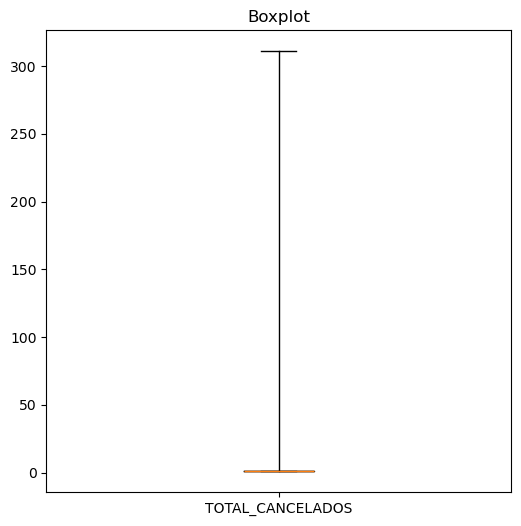

In [79]:
#TOTAL_ATIVOS
#TOTAL_ADERIDOS
#TOTAL_CANCELADOS
df_quantiles2 = df_agrupado.filter(
    #(col("ID_CMPT_MOVEL") == "2025-01")
    (col("ID_CMPT_MOVEL").isin("2025-05"))
)
df_quantiles3 = df_quantiles2.filter(
    (col("TOTAL_CANCELADOS") >0)
)
df_quantiles=df_quantiles3
#df_quantiles=df_filtrado6
col_name = "TOTAL_CANCELADOS"
quantiles = df_quantiles.approxQuantile(col_name, [0.0, 0.25, 0.5, 0.75, 1.0], 0.01)
min_val, q1, median, q3, max_val = quantiles
print(f"Quantis: min={min_val}, Q1={q1}, mediana={median}, Q3={q3}, max={max_val}")
boxplot_stats = [{
    'label': 'TOTAL_CANCELADOS',  # coloque aqui o nome da sua variável
    'whislo': min_val,
    'q1': q1,
    'med': median,
    'q3': q3,
    'whishi': max_val,
    'fliers': []
}]

# Criar o gráfico
fig, ax = plt.subplots(figsize=(6, 6))
ax.bxp(boxplot_stats, showfliers=False)
#ax.set_ylim(min_val - 0.0, max_val + 1000)  # zoom de 0.1 para cima e para baixo
#ax.set_yscale('log')
ax.set_title("Boxplot")
plt.show()


